In [24]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import uproot
import fnmatch
import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi


In [25]:
import ROOT
import awkward as ak
import numpy as np

def write_ak_to_root(output_path, branches, verbose=True):
    """
    Write awkward-array branches to a ROOT TTree.

    Parameters:
    -----------
    output_path : str
        Path to save the ROOT file.
    branches : dict
        Dictionary of branch name -> ak.Array
    verbose : bool
        If True, prints progress.
    """
    fout = ROOT.TFile(output_path, "RECREATE")
    tree = ROOT.TTree("events", "Smear events")

    # Prepare vectors
    vector_dict = {}
    for name, array in branches.items():
        # Determine type from first element
        first_elem = ak.to_numpy(array[0])
        if isinstance(first_elem, (int, np.integer)):
            vec = ROOT.std.vector("int")()
        else:
            vec = ROOT.std.vector("float")()
        tree.Branch(name, vec)
        vector_dict[name] = vec

    n_events = len(next(iter(branches.values())))

    for i in range(n_events):
        if verbose and i % 100 == 0:
            print(f'Processing event {i}/{n_events}', end='\r', flush=True)

        # Clear vectors
        for vec in vector_dict.values():
            vec.clear()

        # Fill vectors
        for name, vec in vector_dict.items():
            data = branches[name][i]

            # Scalars (push directly)
            if np.isscalar(data):
                vec.push_back(data)
            else:
                # iterate jagged/list arrays
                for val in data:
                    vec.push_back(float(val))

        tree.Fill()

    tree.Write()
    fout.Close()
    if verbose:
        print(f"\nSaved ROOT file: {output_path}")


In [26]:
files = sorted(os.listdir(f'../muography/data/'))
target_files = fnmatch.filter(files, "four_detector_target_*_2.root")
free_files = fnmatch.filter(files, "four_detector_free_*_2.root")
files = np.concatenate([target_files,free_files])

for j, file in enumerate(files):
    if 'merge' in file: continue
    with ur.open('~/muography/data/'+file+":events") as f:
        arrays = f.arrays(filter_name=["MuographyHits.energy", "MuographyHitsContributions.time", "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", "MCParticles.PDG", "MCParticles.generatorStatus", "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", "MCParticles.vertex.x", "MCParticles.vertex.y", "MCParticles.vertex.z", "MCParticles.mass"])
    
    y,x=np.histogram(ak.flatten(arrays["MuographyHits.energy"]), bins=100, range=(0, 0.004))
    bc=(x[1:]+x[:-1])/2
    MIP=list(bc[y==max(y[3:])])[0] 
    plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
    plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
    plt.xlabel('Cell Energy (MeV)')
    plt.legend()
    plt.close()
    
    data_energy = arrays[f'MuographyHits.energy']
    
    sigma = 0.56
    
    # flatten to numpy
    flat = ak.to_numpy(data_energy.layout.content)
    noise = np.random.normal(0, sigma, size=len(flat))*MIP
    
    # add noise
    flat_smear = np.clip(flat + noise, a_min=1e-16, a_max=None)
    
    offsets = ak.to_numpy(data_energy.layout.offsets)  # convert Index64 → numpy
    lengths = offsets[1:] - offsets[:-1]
    data_energy_smear = ak.unflatten(flat_smear, lengths)
    
    data_MIP_cut = data_energy_smear > 0.2*MIP
    data_cell_cut = ak.num(arrays[f'MuographyHits.energy'], axis=1) >= 2
    
    data_energy = data_energy[data_cell_cut]
    data_energy_smear = data_energy_smear[data_cell_cut]
    data_x = arrays[f'MuographyHits.position.x'][data_cell_cut]
    data_y = arrays[f'MuographyHits.position.y'][data_cell_cut]
    data_z = arrays[f'MuographyHits.position.z'][data_cell_cut]    
    reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
    data_theta = ak.Array(reco_data_angle[:,0])
    data_phi = ak.Array(reco_data_angle[:,1])
    status = arrays["MCParticles.generatorStatus"]
    mc_px = arrays["MCParticles.momentum.x"][status==1][data_cell_cut]
    mc_py = arrays["MCParticles.momentum.y"][status==1][data_cell_cut]
    mc_pz = arrays["MCParticles.momentum.z"][status==1][data_cell_cut]
    mc_x = arrays["MCParticles.vertex.x"][status==1][data_cell_cut]
    mc_y = arrays["MCParticles.vertex.y"][status==1][data_cell_cut]
    mc_z = arrays["MCParticles.vertex.z"][status==1][data_cell_cut]
    mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
    mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)
    mc_PDG = arrays["MCParticles.PDG"][status==1][data_cell_cut]
    mc_mass = arrays["MCParticles.mass"][status==1][data_cell_cut]
    
    data_time = arrays["MuographyHitsContributions.time"][data_cell_cut]
    status = status[status==1][data_cell_cut]
    detector = np.full(len(status), int(file.split('_')[3]), dtype=np.int32)
    branches = {
        "MuographyHits.detector": ak.Array(detector),
        "MuographyHits.position.x": ak.Array(data_x),
        "MuographyHits.position.y": ak.Array(data_y),
        "MuographyHits.position.z": ak.Array(data_z),
        "MuographyHits.energy_nonsmear": ak.Array(data_energy),
        "MuographyHits.energy": ak.Array(data_energy_smear),
        "MuographyHits.time": ak.Array(data_time),
        "MuographyHits.theta": ak.Array(data_theta),
        "MuographyHits.phi": ak.Array(data_phi),
        "MCParticles.theta": ak.Array(mc_theta),
        "MCParticles.phi": ak.Array(mc_phi),
        "MCParticles.generatorStatus": ak.Array(status),
        "MCParticles.PDG": ak.Array(mc_PDG),
        "MCParticles.mass": ak.Array(mc_mass),
        "MCParticles.momentum.x": ak.Array(mc_px),
        "MCParticles.momentum.y": ak.Array(mc_py),
        "MCParticles.momentum.z": ak.Array(mc_pz),
        "MCParticles.vertex.x": ak.Array(mc_x),
        "MCParticles.vertex.y": ak.Array(mc_y),
        "MCParticles.vertex.z": ak.Array(mc_z),
    }   

    output_file = f"data/{file}_smear.root"
    write_ak_to_root(output_file, branches)
        
print('Done')

Processing event 173600/173692
Saved ROOT file: data/four_detector_target_0_2.root_smear.root
Processing event 77700/77705
Saved ROOT file: data/four_detector_target_1_2.root_smear.root
Processing event 36600/36668
Saved ROOT file: data/four_detector_target_2_2.root_smear.root
Processing event 15900/15981
Saved ROOT file: data/four_detector_target_3_2.root_smear.root
Processing event 173600/173661
Saved ROOT file: data/four_detector_free_0_2.root_smear.root
Processing event 71600/71648
Saved ROOT file: data/four_detector_free_1_2.root_smear.root
Processing event 35700/35703
Saved ROOT file: data/four_detector_free_2_2.root_smear.root
Processing event 14900/14982
Saved ROOT file: data/four_detector_free_3_2.root_smear.root
Done


In [31]:
import ROOT
import awkward as ak

# Create ROOT file and TTree
fout = ROOT.TFile(f"data/{file}_smear.root", "RECREATE")
tree = ROOT.TTree("events", "Smear events")

# MuographyHits vectors
vec_x = ROOT.std.vector("float")()
vec_y = ROOT.std.vector("float")()
vec_z = ROOT.std.vector("float")()
vec_energy = ROOT.std.vector("float")()
vec_energy_nonsmear = ROOT.std.vector("float")()
vec_time = ROOT.std.vector("float")()
vec_theta = ROOT.std.vector("float")()
vec_phi = ROOT.std.vector("float")()

# MCParticles vectors
mc_theta_v = ROOT.std.vector("float")()
mc_phi_v = ROOT.std.vector("float")()
mc_status_v = ROOT.std.vector("int")()
mc_PDG_v = ROOT.std.vector("int")()
mc_mass_v = ROOT.std.vector("float")()
mc_px_v = ROOT.std.vector("float")()
mc_py_v = ROOT.std.vector("float")()
mc_pz_v = ROOT.std.vector("float")()
mc_x_v = ROOT.std.vector("float")()
mc_y_v = ROOT.std.vector("float")()
mc_z_v = ROOT.std.vector("float")()

# Create branches
tree.Branch("MuographyHits.position.x", vec_x)
tree.Branch("MuographyHits.position.y", vec_y)
tree.Branch("MuographyHits.position.z", vec_z)
tree.Branch("MuographyHits.energy", vec_energy)
tree.Branch("MuographyHits.energy_nonsmear", vec_energy_nonsmear)
tree.Branch("MuographyHits.time", vec_time)
tree.Branch("MuographyHits.theta", vec_theta)
tree.Branch("MuographyHits.phi", vec_phi)

tree.Branch("MCParticles.theta", mc_theta_v)
tree.Branch("MCParticles.phi", mc_phi_v)
tree.Branch("MCParticles.generatorStatus", mc_status_v)
tree.Branch("MCParticles.PDG", mc_PDG_v)
tree.Branch("MCParticles.mass", mc_mass_v)
tree.Branch("MCParticles.momentum.x", mc_px_v)
tree.Branch("MCParticles.momentum.y", mc_py_v)
tree.Branch("MCParticles.momentum.z", mc_pz_v)
tree.Branch("MCParticles.vertex.x", mc_x_v)
tree.Branch("MCParticles.vertex.y", mc_y_v)
tree.Branch("MCParticles.vertex.z", mc_z_v)

# Number of events
n_events = len(data_x)

for i in range(n_events):
    if i%100 == 0:
        print(f'Processing: {i} event', end='\r',flush=True)
    # Clear vectors
    vec_x.clear(); vec_y.clear(); vec_z.clear()
    vec_energy.clear(); vec_energy_nonsmear.clear()
    vec_time.clear(); vec_theta.clear(); vec_phi.clear()
    
    mc_theta_v.clear(); mc_phi_v.clear(); mc_status_v.clear()
    mc_PDG_v.clear(); mc_mass_v.clear(); mc_px_v.clear()
    mc_py_v.clear(); mc_pz_v.clear(); mc_x_v.clear()
    mc_y_v.clear(); mc_z_v.clear()

    # Fill MuographyHits (jagged arrays)
    for xi in data_x[i]: vec_x.push_back(float(xi))
    for yi in data_y[i]: vec_y.push_back(float(yi))
    for zi in data_z[i]: vec_z.push_back(float(zi))
    for e in data_energy_smear[i]: vec_energy.push_back(float(e))
    for e_ns in data_energy[i]: vec_energy_nonsmear.push_back(float(e_ns))
    for t in data_time[i]: vec_time.push_back(float(t))

    # Fill MuographyHits scalars
    vec_theta.push_back(float(data_theta[i]))
    vec_phi.push_back(float(data_phi[i]))

    # Fill MCParticles (jagged arrays if applicable)
    if isinstance(mc_px[i], ak.Array) or isinstance(mc_px[i], list):
        for px, py, pz, x, y, z, pdg, s, th, ph, m in zip(
            mc_px[i], mc_py[i], mc_pz[i],
            mc_x[i], mc_y[i], mc_z[i],
            mc_PDG[i], status[i],
            mc_theta[i], mc_phi[i], mc_mass[i]
        ):
            mc_px_v.push_back(float(px))
            mc_py_v.push_back(float(py))
            mc_pz_v.push_back(float(pz))
            mc_x_v.push_back(float(x))
            mc_y_v.push_back(float(y))
            mc_z_v.push_back(float(z))
            mc_PDG_v.push_back(int(pdg))
            mc_status_v.push_back(int(s))
            mc_theta_v.push_back(float(th))
            mc_phi_v.push_back(float(ph))
            mc_mass_v.push_back(float(m))
    else:
        # Scalars per event
        mc_px_v.push_back(float(mc_px[i]))
        mc_py_v.push_back(float(mc_py[i]))
        mc_pz_v.push_back(float(mc_pz[i]))
        mc_x_v.push_back(float(mc_x[i]))
        mc_y_v.push_back(float(mc_y[i]))
        mc_z_v.push_back(float(mc_z[i]))
        mc_PDG_v.push_back(int(mc_PDG[i]))
        mc_status_v.push_back(int(status[i]))
        mc_theta_v.push_back(float(mc_theta[i]))
        mc_phi_v.push_back(float(mc_phi[i]))
        mc_mass_v.push_back(float(mc_mass[i]))

    # Fill tree for this event
    tree.Fill()

# Write and close file
tree.Write()
fout.Close()


In [6]:
with ur.open(f"data/four_detector_free_1_2.root_smear.root:events") as f:
    arrays = f.arrays()


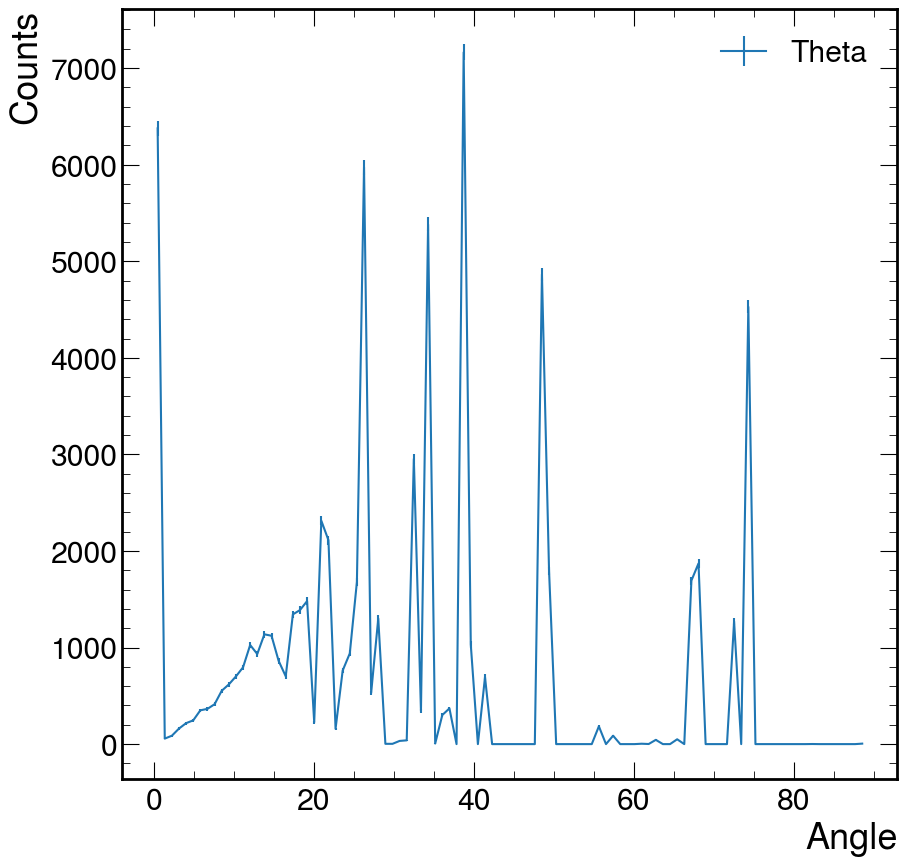

In [19]:
with ur.open(f"data/four_detector_free_1_2.root_smear.root:events") as f:
    arrays = f.arrays()

y,x=np.histogram(ak.flatten(arrays["MuographyHits.theta"]), bins=100)
bc=(x[1:]+x[:-1])/2
MIP=list(bc[y==max(y)])[0] 
plt.errorbar(np.array(bc),np.array(y),yerr=np.sqrt(y),label=f'Theta')

y,x=np.histogram(ak.flatten(arrays["MuographyHits.phi"]), bins=17)
bc=(x[1:]+x[:-1])/2
MIP=list(bc[y==max(y[2:])])[0] 
#plt.errorbar(np.array(bc),np.array(y),yerr=np.sqrt(y),label=f'Phi')

plt.xlabel('Angle')
plt.ylabel('Counts')
#plt.yscale('log')
plt.legend()

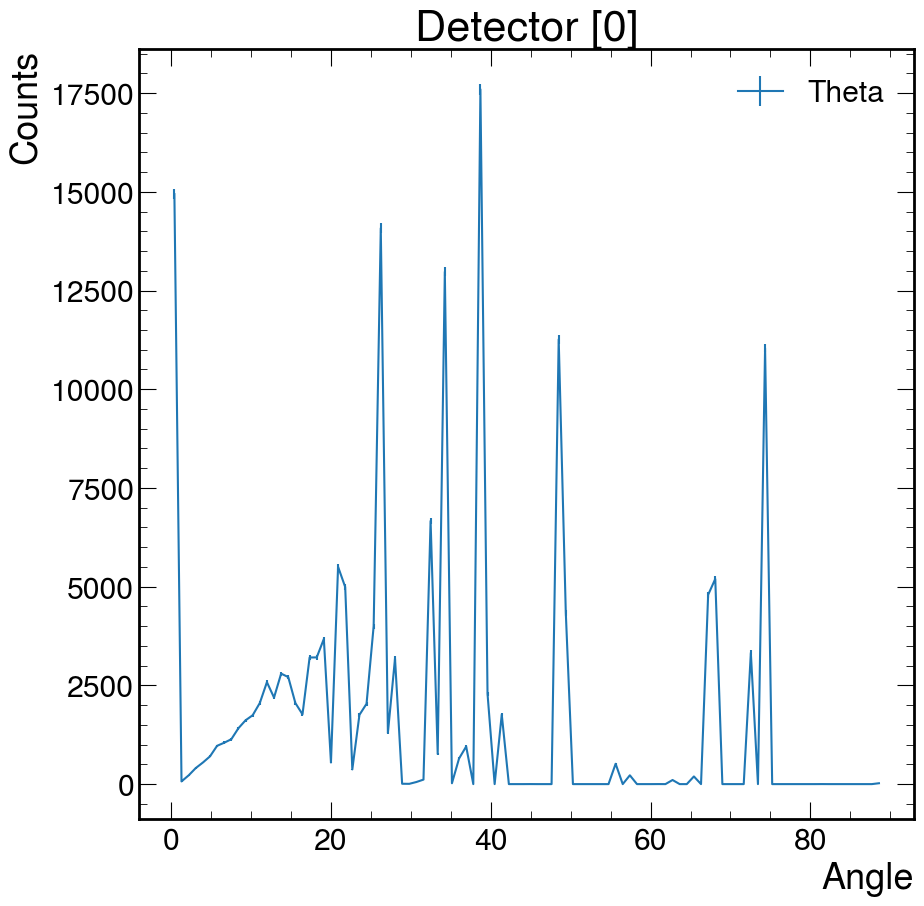

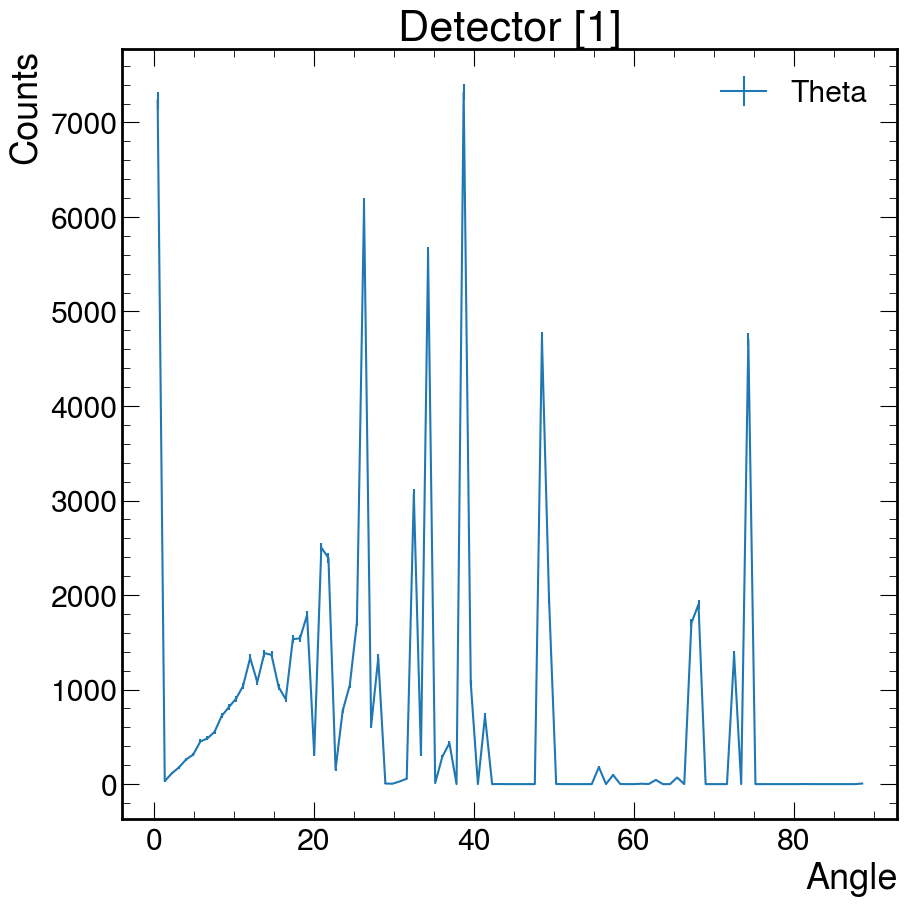

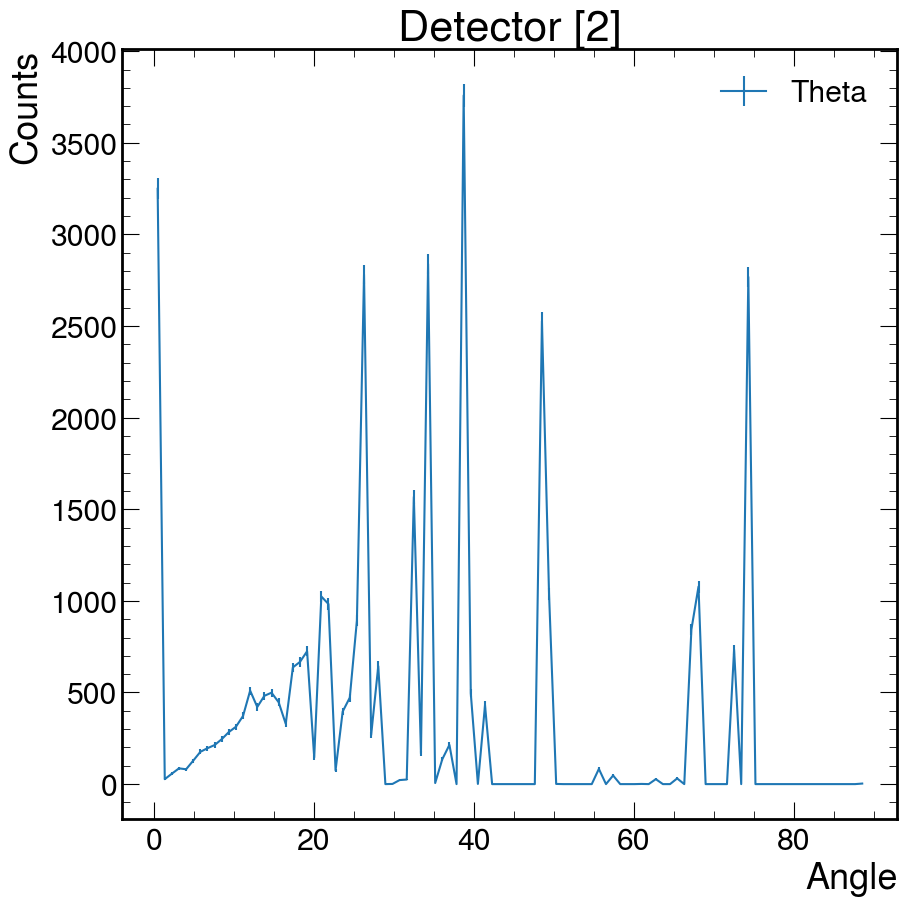

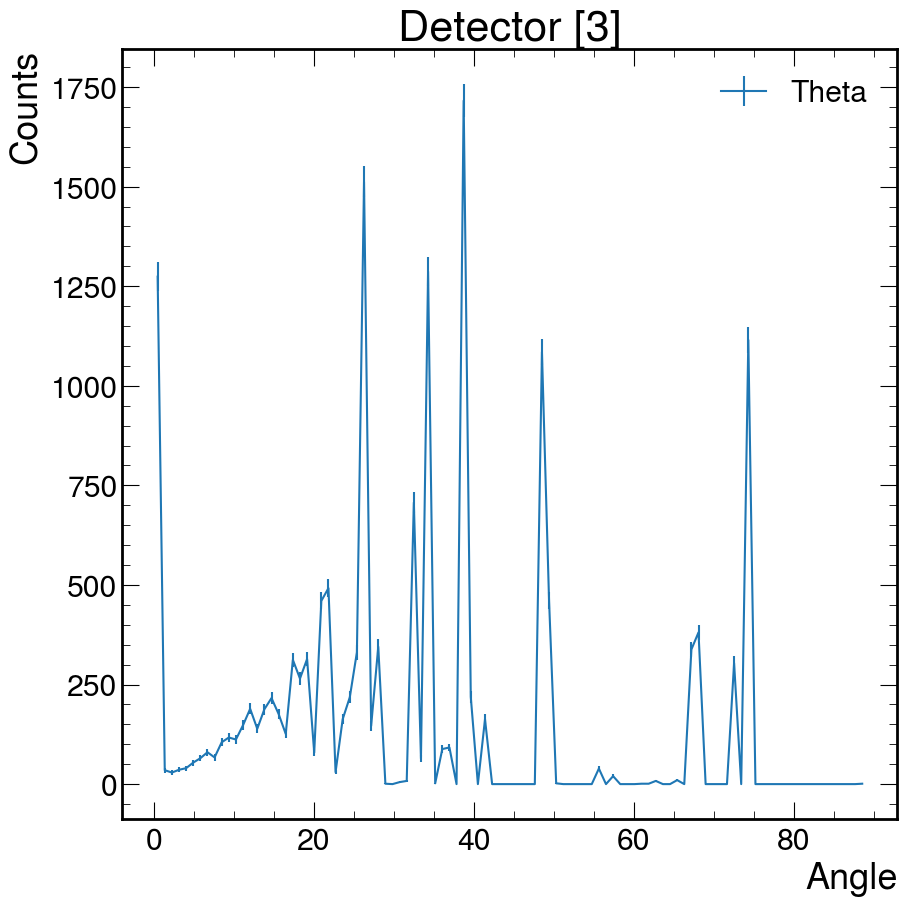

In [27]:
#plt.hist(ak.flatten(arrays["MuographyHits.energy_nonsmear"]),bins=100,histtype='step',label='Non-Smear')
#plt.hist(ak.flatten(arrays["MuographyHits.energy"]),bins=100,histtype='step',label='Smear')

files = sorted(os.listdir(f'data/'))
target_files = fnmatch.filter(files, "four_detector_target_*root_smear.root")
free_files   = fnmatch.filter(files, "four_detector_free_*root_smear.root")
files = np.concatenate([target_files,free_files])

for j, file in enumerate(target_files):
    with ur.open(f"data/{file}:events") as f:
        arrays = f.arrays()
    detector = arrays["MuographyHits.detector"][0]
    y,x=np.histogram(ak.flatten(arrays["MuographyHits.energy_nonsmear"]), bins=100, range=(0, 0.004))
    bc=(x[1:]+x[:-1])/2
    MIP=list(bc[y==max(y)])[0] 
    #plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y),label=f'Non-Smear, MIP = {MIP*1000:.2f} MeV')
    #plt.axvline(0.2*MIP*1000,label=f'Non-Smear, MIP = {MIP*1000:.2f} MeV')
    
    y,x=np.histogram(ak.flatten(arrays["MuographyHits.energy"]), bins=100, range=(0, 0.004))
    bc=(x[1:]+x[:-1])/2
    MIP=list(bc[y==max(y[2:])])[0] 
    #plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y),label=f'Smear, MIP = {MIP*1000:.2f} MeV')
    #plt.axvline(0.2*MIP*1000,label=f'Smear, MIP = {MIP*1000:.2f} MeV')

    y,x=np.histogram(ak.flatten(arrays["MuographyHits.theta"]), bins=100)
    bc=(x[1:]+x[:-1])/2
    MIP=list(bc[y==max(y)])[0] 
    plt.errorbar(np.array(bc),np.array(y),yerr=np.sqrt(y),label=f'Theta')

    plt.xlabel('Angle')
    #plt.xlabel('Cell Energy (MeV)')
    plt.ylabel('Counts')
    #plt.yscale('log')
    plt.title(f'Detector {detector}')
    plt.legend()
    plt.show()

In [ ]:
import ROOT
import numpy as np
import os
import fnmatch

# Functions using TVector3
def phi_reconstruct(x, y, z):
    vec = ROOT.TVector3(x, y, z)
    return vec.Phi() * 180.0 / np.pi  # degrees

def theta_reconstruct(x, y, z):
    vec = ROOT.TVector3(x, y, z)
    return vec.Theta() * 180.0 / np.pi  # degrees

def vector_angle_reconstruct(x_array, y_array, z_array):
    data = np.vstack((x_array, y_array, z_array)).T
    datamean = data.mean(axis=0)
    centered = data - datamean
    _, _, vv = np.linalg.svd(centered)
    direction = vv[0]
    if direction[2] > 0:
        direction *= -1
    return theta_reconstruct(*direction), phi_reconstruct(*direction)

# Get files
files = sorted(os.listdir('../muography/data/'))
target_files = fnmatch.filter(files, "four_detector_target_*_2.root")
free_files   = fnmatch.filter(files, "four_detector_free_*_2.root")
files = target_files + free_files

for file in free_files:
    if 'merge' in file: 
        continue

    fin = ROOT.TFile.Open(f'../muography/data/{file}')
    tree = fin.Get('events')

    # Use RDataFrame to read branches into numpy arrays
    rdf = ROOT.RDataFrame(tree)
    arrays = rdf.AsNumpy([
        "MuographyHits.energy",
        "MuographyHitsContributions.time",
        "MuographyHits.position.x",
        "MuographyHits.position.y",
        "MuographyHits.position.z",
        "MCParticles.PDG",
        "MCParticles.generatorStatus",
        "MCParticles.momentum.x",
        "MCParticles.momentum.y",
        "MCParticles.momentum.z",
        "MCParticles.vertex.x",
        "MCParticles.vertex.y",
        "MCParticles.vertex.z",
        "MCParticles.mass"
    ])

    # Compute MIP
    hist, edges = np.histogram(np.concatenate(arrays["MuographyHits.energy"]), bins=100, range=(0,0.004))
    bc = (edges[1:] + edges[:-1])/2
    MIP = bc[np.argmax(hist)]
    
    # Smearing
    sigma = 0.56
    flat = np.concatenate(arrays["MuographyHits.energy"])
    noise = np.random.normal(0, sigma, size=len(flat)) * MIP
    flat_smear = np.clip(flat + noise, 1e-16, None)
    
    # Reconstruct theta/phi
    data_x = np.concatenate(arrays["MuographyHits.position.x"])
    data_y = np.concatenate(arrays["MuographyHits.position.y"])
    data_z = np.concatenate(arrays["MuographyHits.position.z"])
    
    for i, (ex, ey, ez) in enumerate(zip(arrays["MuographyHits.position.x"],
                                         arrays["MuographyHits.position.y"],
                                         arrays["MuographyHits.position.z"])):
        x_arr = np.array(ex)
        y_arr = np.array(ey)
        z_arr = np.array(ez)
        
        # Skip empty events
        if len(x_arr) < 2:
            continue
    
        theta_val, phi_val = vector_angle_reconstruct(x_arr, y_arr, z_arr)
        # store per-event vectors in ROOT tree here


    # Prepare output ROOT file
    fout = ROOT.TFile(f'data/{file}_smear.root', 'RECREATE')
    out_tree = ROOT.TTree('events', 'Smear events')

    # Define branches
    pos_x = ROOT.std.vector('float')()
    pos_y = ROOT.std.vector('float')()
    pos_z = ROOT.std.vector('float')()
    energy = ROOT.std.vector('float')()
    energy_nonsmear = ROOT.std.vector('float')()
    time = ROOT.std.vector('float')()
    theta = ROOT.std.vector('float')()
    phi = ROOT.std.vector('float')()

    out_tree.Branch('MuographyHits.position.x', pos_x)
    out_tree.Branch('MuographyHits.position.y', pos_y)
    out_tree.Branch('MuographyHits.position.z', pos_z)
    out_tree.Branch('MuographyHits.energy', energy)
    out_tree.Branch('MuographyHits.energy_nonsmear', energy_nonsmear)
    out_tree.Branch('MuographyHits.time', time)
    out_tree.Branch('MuographyHits.theta', theta)
    out_tree.Branch('MuographyHits.phi', phi)

    # Fill vectors (here filling one event with all hits)
    pos_x.clear()
    pos_y.clear()
    pos_z.clear()
    energy.clear()
    energy_nonsmear.clear()
    time.clear()
    theta.clear()
    phi.clear()

    for x, y, z, e, en, t in zip(data_x, data_y, data_z, flat_smear, flat, np.concatenate(arrays["MuographyHitsContributions.time"])):
        pos_x.push_back(x)
        pos_y.push_back(y)
        pos_z.push_back(z)
        energy.push_back(e)
        energy_nonsmear.push_back(en)
        time.push_back(t)
        theta.push_back(theta_val)
        phi.push_back(phi_val)

    out_tree.Fill()
    fout.Write()
    fout.Close()
    fin.Close()

print("Done")


In [73]:
import ROOT

input_file = '~/muography/data/square_4x4x8.root'
output_file = 'data/square_4x4x8_smear.root'

# Open input ROOT file
fin = ROOT.TFile.Open(input_file)
tree = fin.Get("events")

# Create output ROOT file
fout = ROOT.TFile.Open(output_file, "RECREATE")
out_tree = tree.CloneTree(0)  # clone the tree structure but not the entries yet

# Get all branch names
branches = [b.GetName() for b in tree.GetListOfBranches()]

# Decide which branches to keep
branches_to_keep = [b for b in branches if 'nMuographyHits' not in b and 'nMCParticles' not in b and 'GP' not in b]

# Disable all branches first
tree.SetBranchStatus("*", 0)
# Enable only the ones we want
for b in branches_to_keep:
    tree.SetBranchStatus(b, 1)

# Loop over entries and fill the new tree
for i in range(tree.GetEntries()):
    tree.GetEntry(i)
    out_tree.Fill()

# Write the new tree and close the files
fout.Write()
fout.Close()
fin.Close()


In [64]:
print(uproot.__version__)
print(ak.__version__)

5.0.5
2.6.6


In [72]:
print(ROOT.__version__)

6.32.14


In [5]:
path_to_result = "training/128_25depth/model"
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']
predictions_theta = np.degrees(predictions_unnormalized["theta"])
targets_theta = np.degrees(targets_unnormalized["theta"])

In [11]:
import os
import pickle
import awkward as ak
import uproot as ur

files = sorted(os.listdir('training/128_channel_test/'))
merged = None

for type in ['free', 'target']:
    for i, file in enumerate(files[:5]):
        if type not in file: continue
        with ur.open(f'training/128_channel_test/{file}:events') as f:
            arrays = f.arrays()
    
        print(f'Processing: {file}', end='\r',flush=True)
    
        cut = [file in i for i in meta[:, 0]]
        arrays["GNN.theta"] = ak.Array(predictions_theta[cut])
        
        arrays["Detector"] = np.full(len(arrays), int(file.split('_')[3]), dtype=np.int32)
        branches = {
            "Detector": arrays["Detector"],
            "MuographyHits.position.x": arrays[f"MuographyHits.position.x"],
            "MuographyHits.position.y": arrays[f"MuographyHits.position.y"],
            "MuographyHits.position.z": arrays[f"MuographyHits.position.z"],
            "MuographyHits.energy": arrays[f"MuographyHits.energy"],
            "MuographyHits.time": arrays[f"MuographyHits.time"],
            "MCParticles.PDG": arrays["MCParticles.PDG"],
            "MCParticles.generatorStatus": arrays["MCParticles.generatorStatus"],
            "MCParticles.mass": arrays["MCParticles.mass"],
            "MCParticles.momentum.x": arrays["MCParticles.momentum.x"],
            "MCParticles.momentum.y": arrays["MCParticles.momentum.y"],
            "MCParticles.momentum.z": arrays["MCParticles.momentum.z"],
            "MCParticles.theta": arrays["MCParticles.theta"],
            "MCParticles.phi": arrays["MCParticles.phi"],
            "GNN.theta": arrays["GNN.theta"],
        }
        batch = ak.Array(branches)
    
        # Concatenate across files
        merged = batch if merged is None else ak.concatenate([merged, batch], axis=0)
    with uproot.recreate(f"training/128_model/{type}_merge.root") as fout:
        fout.mktree(
            "events",
            {
                "Detector": "int32",
                "MuographyHits.position.x": "var * float32",
                "MuographyHits.position.y": "var * float32",
                "MuographyHits.position.z": "var * float32",
                "MuographyHits.energy": "var * float32",
                "MuographyHits.time": "var * float32",
                "MCParticles.PDG": "var * int32",
                "MCParticles.generatorStatus": "var * int32",
                "MCParticles.mass": "var * float32",
                "MCParticles.momentum.x": "var * float32",
                "MCParticles.momentum.y": "var * float32",
                "MCParticles.momentum.z": "var * float32",
                "MCParticles.theta": "var * float32",
                "MCParticles.phi": "var * float32",
                "GNN.theta": "float32",
            },
        )
    
        # IMPORTANT: pass a dict of arrays, not ak.to_numpy
        fout["events"].extend({key: merged[key] for key in merged.fields})

TypeError: do not try to convert low-level layouts (Content subclasses) into NumPy arrays; put them in ak.highlevel.Array

In [20]:
import uproot
def save_file_with_gnn(meta_info, GNN_predictions, GNN_truth, data_directory):
    file_and_eventnumber_to_index = {}
    file_names = meta_info[:, 0]
    unique_file_names = np.unique(file_names)
    for unique_name in unique_file_names:
        file_and_eventnumber_to_index[unique_name] = {}
    for i, (file_name, event_number, particle_type) in enumerate(meta_info):
        file_and_eventnumber_to_index[file_name][event_number] = i
    
    for file_name in unique_file_names:
        with uproot.open(file_name+":events") as f:
            file_arrays = f.arrays()
        fields_to_save = [field for field in file_arrays.fields if 'nHcalFarForwardZDCHits' not in field and 'nMCParticles' not in field]
        output_data = {}
        for field in fields_to_save:
            output_data[field] = file_arrays[field]
        num_events = len(file_arrays)
        gnn_preds, gnn_truths = [], []
        for event_number in range(num_events):
            # Find the global index for this (file, event_number)
            idx = file_and_eventnumber_to_index[file_name].get(f"{int(event_number)}", None)
            if idx is None:
                gnn_preds.append(None)
                gnn_truths.append(None)# skip if event isn't in meta_info
            
            gnn_preds.append(GNN_predictions[idx])
            gnn_truths.append(GNN_truth[idx])
        output_data["Detector"] = np.full(len(gnn_preds), int(file_name.split('/')[-1].split('_')[3]), dtype=np.int32)
        output_data["GNN_theta"] = ak.Array(gnn_preds)
        # output_data["GNN_true_theta"] = ak.Array(gnn_truths)
        base_name = os.path.basename(file_name) 
        base_name = base_name.replace(".root", "") 
        if not os.path.exists(data_directory):
            os.makedirs(data_directory)
        save_path = os.path.join(data_directory, f"{base_name}_withGNN.root")
        with uproot.recreate(save_path) as fout:
            fout["events"] = output_data

In [21]:
path_to_result = "training/128_25depth/model"
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']
predictions_theta = np.degrees(predictions_unnormalized["theta"])
targets_theta = np.degrees(targets_unnormalized["theta"])
predictions_phi = np.degrees(predictions_unnormalized["phi"])
targets_phi = np.degrees(targets_unnormalized["phi"])

In [54]:
import uproot
meta_info = meta
GNN_predictions = predictions_theta
GNN_truth = targets_theta
data_directory = "training/128_channel_test/"
file_and_eventnumber_to_index = {}
file_names = meta_info[:, 0]
unique_file_names = np.unique(file_names)
for unique_name in unique_file_names:
    file_and_eventnumber_to_index[unique_name] = {}
for i, (file_name, event_number, particle_type) in enumerate(meta_info):
    file_and_eventnumber_to_index[file_name][event_number] = i

for file_name in unique_file_names:
    with uproot.open(file_name+":events") as f:
        file_arrays = f.arrays()
    fields_to_save = [field for field in file_arrays.fields if 'nHcalFarForwardZDCHits' not in field and 'nMCParticles' not in field]
    output_data = {}
    for field in fields_to_save:
        output_data[field] = file_arrays[field]
    num_events = len(file_arrays)
    gnn_preds, gnn_truths = [], []
    detector = []
    det_id = int(file_name.split('/')[-1].split('_')[3])
    for event_number in range(num_events):
        # Find the global index for this (file, event_number)
        idx = file_and_eventnumber_to_index[file_name].get(f"{int(event_number)}", None)
        if idx is None:
            detector.append(det_id)
            gnn_preds.append(None)
            gnn_truths.append(None)# skip if event isn't in meta_info
        detector.append(det_id)
        gnn_preds.append(GNN_predictions[idx])
        gnn_truths.append(GNN_truth[idx])
    #output_data["Detector"] = ak.Array(np.array(detector, dtype=np.int32))
    #output_data["GNN_theta"] = ak.Array(np.array(gnn_preds, dtype=np.float64))
    # output_data["GNN_true_theta"] = ak.Array(gnn_truths)
    base_name = os.path.basename(file_name) 
    base_name = base_name.replace(".root", "") 
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)
    save_path = os.path.join(data_directory, f"{base_name}_withGNN.root")

    with uproot.recreate(save_path) as fout:
        fout["events"] = output_data

TypeError: do not try to convert low-level layouts (Content subclasses) into NumPy arrays; put them in ak.highlevel.Array

In [88]:
ids = []
for i in range(len(meta)):
    ids.append(int(meta[i][0].split('.root')[0].split('_')[-2]))

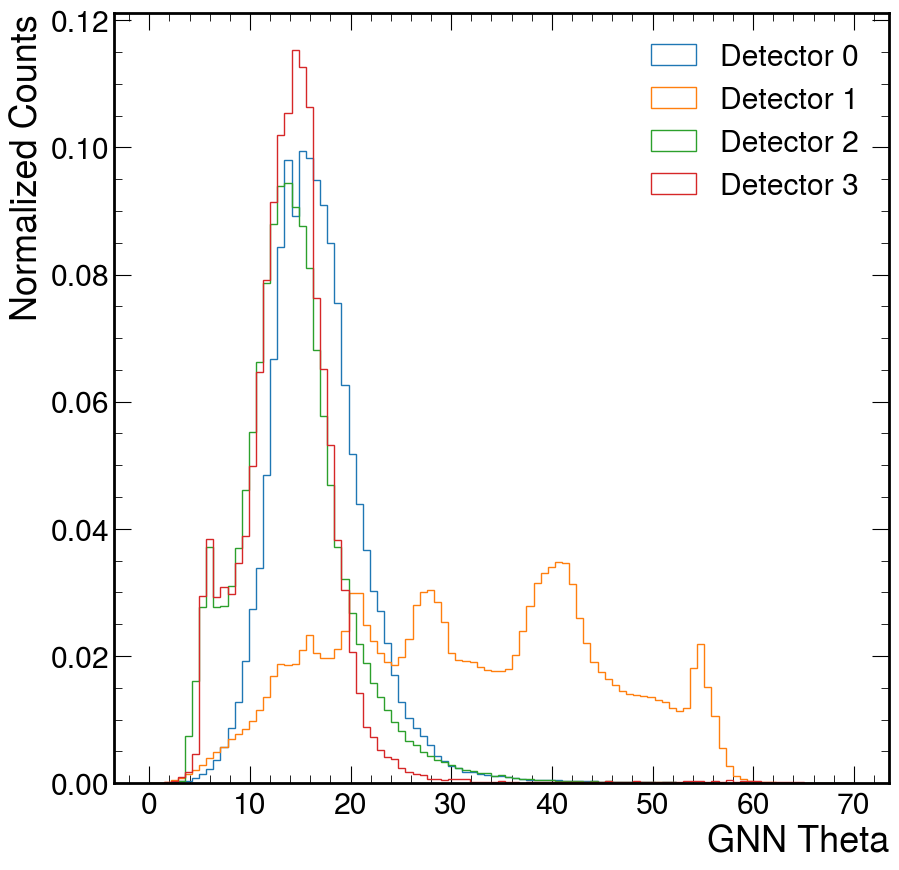

In [95]:
for id in set(ids):
    cut = np.array(ids) == id
    plt.hist(predictions_theta[cut],bins=np.linspace(0,70,100),histtype='step',label=f'Detector {id}',density=True)
plt.xlabel('GNN Theta')
plt.ylabel('Normalized Counts')
plt.legend()

In [57]:
import awkward as ak

output_data_fixed = {}
for k, v in output_data.items():
    if not isinstance(v, ak.highlevel.Array):
        v = ak.Array(v)
    output_data_fixed[k] = v

In [22]:
save_file_with_gnn(
    meta,
    predictions_theta,
    targets_theta,
    "training/128_channel_test/")

TypeError: do not try to convert low-level layouts (Content subclasses) into NumPy arrays; put them in ak.highlevel.Array

In [8]:
import glob
for category in ["target"]:
    files = sorted(glob.glob(f"training/128_test/*{category}*withGNN*.root"))
    arrays = [uproot.open(f"{fname}:events").arrays() for fname in files]
    merged = ak.concatenate(arrays, axis=0)

    # Convert Awkward array schema into dict for mktree
    branch_types = {field: merged[field].type for field in merged.fields}

    with uproot.recreate(f"training/128_model/{category}_merged.root") as fout:
        fout.mktree("events", branch_types)

#hadd merged_withGNN.root four_detector_target_*_withGNN.root

In [29]:
arrays = {}
simfile = 'training/128_25depth/test/merged_withGNN.root'
with ur.open(simfile+":events") as f:
    arrays['muon_data'] = f.arrays()


In [30]:
reco_data_angles = []
reco_sim_angles = []
energies = []
data_GNN = []
sim_GNN = []
sim_energies = []
data_energies = []
sim_theta = []
data_theta = []
i = 1
#detector = arrays['muon_data']['Detector']
data_energy = arrays['muon_data'][f'MuographyHits.energy']*1000

y,x=np.histogram(ak.flatten(data_energy), bins=100, range=(0, 4))
bc=(x[1:]+x[:-1])/2
MIP=list(bc[y==max(y)])[0] 
data_MIP_cut = data_energy > 0.5*MIP/1000
data_cell_cut = ak.num(arrays['muon_data'][f'MuographyHits.energy'][data_MIP_cut], axis=1) >= 2
#data_cell_cut = [True if len(cells)>=2 else False for cells in arrays['muon_data'][f"MuographyHits.energy"][data_MIP_cut]]

data_x = arrays['muon_data'][f'MuographyHits.position.x'][data_cell_cut]
data_y = arrays['muon_data'][f'MuographyHits.position.y'][data_cell_cut]
data_z = arrays['muon_data'][f'MuographyHits.position.z'][data_cell_cut]    
reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
#reco_data_angle_1 = np.array([vector_angle_reconstruct_1(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
reco_data_angles.append(reco_data_angle)
data_energies.append(ak.sum(arrays['muon_data'][f'MuographyHits.energy'][data_MIP_cut][data_cell_cut],axis=-1))
data_GNN.append(arrays['muon_data'][f'GNN_theta'][data_cell_cut])
mc_px = arrays['muon_data']["MCParticles.momentum.x"][data_cell_cut]
mc_py = arrays['muon_data']["MCParticles.momentum.y"][data_cell_cut]
mc_pz = arrays['muon_data']["MCParticles.momentum.z"][data_cell_cut]
mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)    
data_theta.append(mc_theta)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


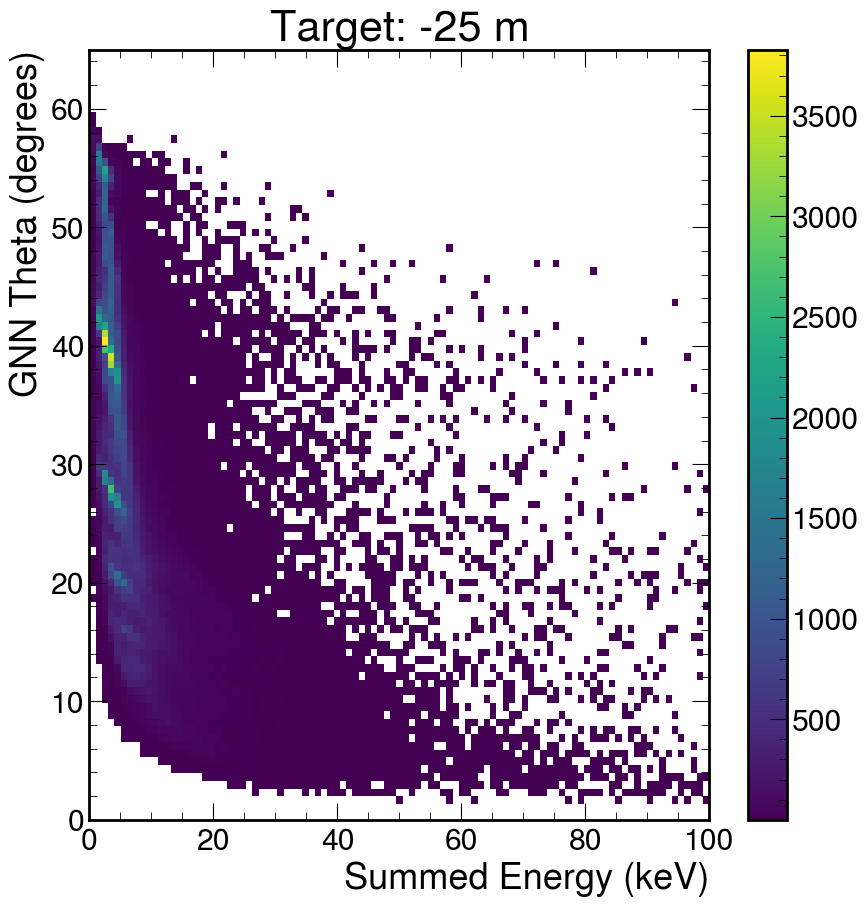

In [31]:
height = [1, -25, -50, -100]
energy_cut = [20,400,600,1500]
for i in range(1):
    plt.hist2d(np.array(data_energies[i])*1000,np.array(data_GNN[i]),bins=[np.linspace(0,100,100),np.linspace(0,65,100)],cmin=1)
    plt.ylabel("GNN Theta (degrees)")
    plt.xlabel("Summed Energy (keV)")
    plt.legend()
    plt.title(f'Target: {height[i+1]} m')
    plt.colorbar()
    plt.show()

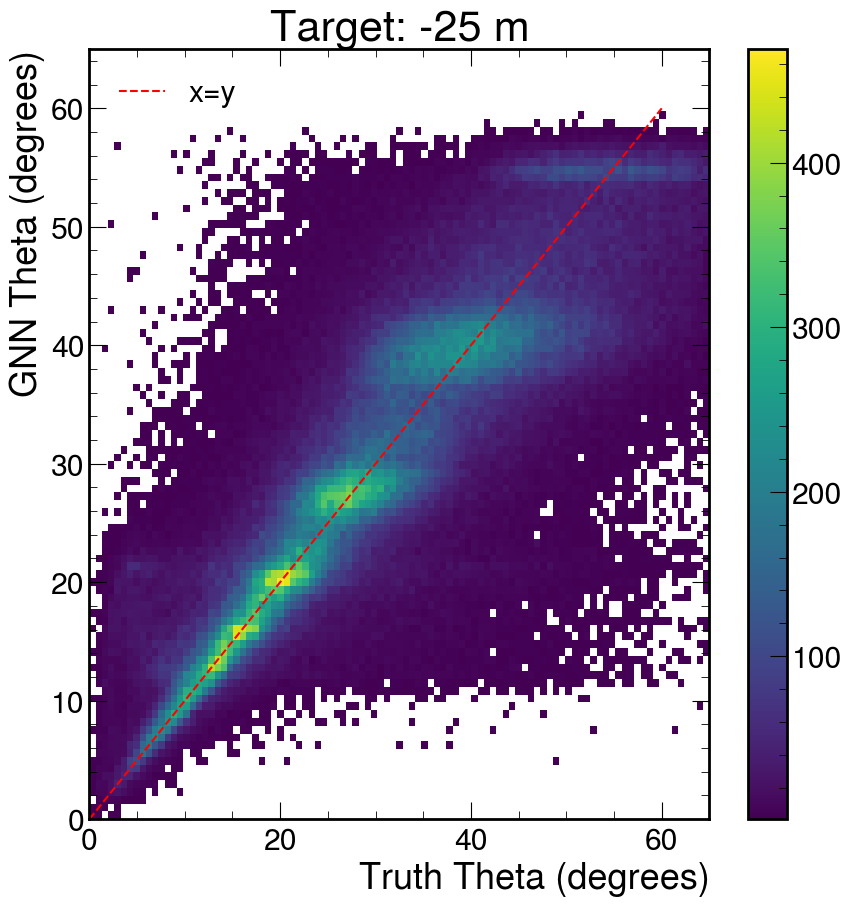

In [40]:
height = [1, -25, -50, -100]
energy_cut = [20,400,600,1500]
for i in range(1):
    plt.hist2d(np.array(ak.flatten(data_theta[i])),np.array(data_GNN[i]),bins=[np.linspace(0,65,100),np.linspace(0,65,100)],cmin=1)
    plt.ylabel("GNN Theta (degrees)")
    plt.xlabel("Truth Theta (degrees)")
    plt.plot([0,60],[0,60],c='r',linestyle='dashed',label='x=y')
    plt.legend()
    plt.title(f'Target: {height[i+1]} m')
    plt.colorbar()
    plt.show()